### Data sources

Inhabitants' median disposable monetary income by postal code area, 2010-2021:

https://pxdata.stat.fi:443/PxWeb/sq/39625562-d250-492a-a190-37bcc355e2a3

Prices per square meter of old dwellings in housing companies and numbers of transactions by postal code area, yearly, 2009-2022:

https://pxdata.stat.fi:443/PxWeb/sq/41826b15-82a9-4c83-8be6-bd77f98b31ac

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from random import randint

# Output control. Set these true, and more output will be generated.
DO_CORRELATION_PLOTS = False
DO_PEEK_IN_DATA = False

# Read in what we've got.
incomes = pd.read_csv('data/003_12f1_2021_20230929-100110.csv',
                      encoding = 'latin1',
                      na_values = [ '0' ],
                      skiprows = [0, 1])
prices = pd.read_csv('data/001_13mu_2022_20230929-105546.csv',
                     encoding = 'latin1',
                     na_values = [ '.', '..', '...' ],
                     skiprows = [0, 1])

# Setup things the way specified above.

# Correlation plots are needed when trying to home on in P, Q, and D values for ARIMA modelling.
# Most of the time they're just unnecessary clutter; so, by default they're not produced.
if DO_CORRELATION_PLOTS:
  import matplotlib.pyplot as plt
  from pandas.plotting import autocorrelation_plot

In [2]:
if DO_PEEK_IN_DATA:
  # A few peeks in to the data we just read.
  print(f'Income/Price data shape: {incomes.shape}/{prices.shape}\n')

  print(incomes.iloc[[randint(0, incomes.shape[0])]].to_string())
  print(prices.iloc[[randint(0, prices.shape[0])]].to_string())

In [3]:
# Drop unwanted columns for ease of use later on.
incomes.drop('Information', axis = 1, inplace = True)
prices.drop([ 'Building type', 'Information' ], axis = 1, inplace = True)

# Postal codes are unique, and they're also used as identifiers in GeoJSON
# containing borders of postal code areas; so, we might separate them from
# more traditional names.
prices.insert(
  loc = 1,
  column = 'Name',
  value = prices['Postal code'].map(lambda _: ' '.join(filter(lambda x: len(x) > 0,
                                                              _.split(' ')[1:])))
)
prices['Postal code'] = prices['Postal code'].map(lambda _: _.split(' ')[0])

incomes.insert(
  loc = 0,
  column = 'Name',
  value = incomes['Postal code area'].map(lambda _: ' '.join(filter(lambda x: len(x) > 0,
                                                                    _.split(' ')[1:])))
)
incomes.insert(loc = 0,
               column = 'Postal code',
               value = incomes['Postal code area'].map(lambda _: _.split(' ')[0]))
incomes.drop('Postal code area', axis = 1, inplace = True)

In [4]:
if DO_PEEK_IN_DATA:
  # A few more peeks into the data, which should now appear more uniform than before.
  print(f'Income/Price data shape: {incomes.shape}/{prices.shape}\n')

  code = incomes.iloc[[randint(0, min(incomes.shape[0], prices.shape[0]))]]['Postal code'].values[0]
  print(incomes.loc[incomes['Postal code'] == code])
  print(prices.loc[prices['Postal code'] == code])

  ax_incomes = incomes.plot()
  ax_incomes.set_xlabel('Postal code')
  ax_incomes.set_ylabel('Median Disposable Income')
  _ = ax_incomes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  ax_prices = prices.plot()
  ax_prices.set_xlabel('Postal code')
  ax_prices.set_ylabel('2 room flat sqm price')
  _ = ax_prices.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [5]:
if DO_CORRELATION_PLOTS:
  plotdata = incomes.drop('Name', axis = 1)
  for r in range(0, incomes.shape[0]):
    postal_code = incomes.iloc[[r]]['Postal code'].values[0]
    name = incomes.iloc[[r]]['Name'].values[0]
    ax = autocorrelation_plot(plotdata.iloc[[r]].T.iloc[1:])

    plt.title(f'{postal_code} {name}')
    plt.show()

In [6]:
if DO_CORRELATION_PLOTS:
  plotdata = prices.drop('Name', axis = 1)
  for r in range(0, prices.shape[0]):
    postal_code = prices.iloc[[r]]['Postal code'].values[0]
    name = prices.iloc[[r]]['Name'].values[0]
    ax = autocorrelation_plot(plotdata.iloc[[r]].T.iloc[1:])

    plt.title(f'{postal_code} {name}')
    plt.show()

### Arima Modelling

In ARIMA modelling below values P=3, Q=1, and D=4 are used. However, the values used originate from (an embarrassingly large set of) trial and error; so, this set of values might not be the best possible values. But, they're _a_ set of values producing no _negative_ predictions, which probably counts for this set's merit.

Documentation:

  https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
  https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html

Some background information for those who might be willing to wade through some:

  https://stats.stackexchange.com/questions/44992
  https://blog.devgenius.io/finding-optimal-p-d-and-q-values-for-your-arima-model-94669a909a35
  https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

In [7]:
income_predictions = []
income_deltas = []
income_percent_deltas = []

for r in range(0, incomes.shape[0]):
  # A few prints every now and then helps when locating where exactly warnings came from.
  print(incomes.iloc[[r]]['Name'].values[0])
  print(incomes.iloc[[r]].to_string())

  history = incomes.drop(['Name', 'Postal code'], axis = 1).rename({ 3: 'Income' }).iloc[[r]].T
  history.index = pd.date_range(freq = 'AS-JAN',
                                periods = len(history.index),
                                start = history.index[0])
  model = ARIMA(history, enforce_stationarity = False, order = (3, 1, 4))
  fitted_model = model.fit()
  prediction = fitted_model.forecast().values[0]

  income_predictions.append(prediction)
  delta = prediction - incomes.iloc[r, incomes.shape[1] - 1]
  income_deltas.append(delta)
  income_percent_deltas.append((delta / prediction) * 100)

  # A few prints every now and then helps when locating where exactly warnings came from.
  print(f'    {prediction}')

incomes.insert(column = str(int(incomes.columns[-1]) + 1),
               loc = incomes.shape[1],
               value = income_predictions)
incomes.insert(column = 'Delta',
               loc = incomes.shape[1],
               value = income_deltas)
incomes.insert(column = 'Delta Percent',
               loc = incomes.shape[1],
               value = income_percent_deltas)

Helsinki keskusta - Etu-Töölö (Helsinki)
  Postal code                                      Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
0       00100  Helsinki keskusta - Etu-Töölö (Helsinki)  23296.0  24089.0  24784.0  25148.0  25607.0  25986.0  26642.0  27577.0  28694.0  29706.0  29258.0  30659.0
    30888.798973067187
Punavuori - Bulevardi (Helsinki)
  Postal code                              Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
1       00120  Punavuori - Bulevardi (Helsinki)  24084.0  24941.0  25865.0  25830.0  26219.0  26284.0  27107.0  27518.0  28726.0  29816.0  29684.0  30668.0
    30923.836080481586
Kaartinkaupunki (Helsinki)
  Postal code                        Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
2       00130  Kaartinkaupunki (Helsinki)  25176.0  24541.0  27

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    30158.019476704736
Kruununhaka (Helsinki)
  Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
6       00170  Kruununhaka (Helsinki)  24669.0  25461.0  26308.0  26729.0  27199.0  27358.0  27846.0  28489.0  29627.0  30720.0  30591.0  31048.0
    31212.633750302914
Kamppi - Ruoholahti (Helsinki)
  Postal code                            Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
7       00180  Kamppi - Ruoholahti (Helsinki)  22646.0  23102.0  23349.0  23518.0  23902.0  24243.0  24898.0  25492.0  26340.0  27075.0  26765.0  27306.0
    27462.019466145925
Suomenlinna (Helsinki)
  Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
8       00190  Suomenlinna (Helsinki)  23115.0  22904.0  23820.0  24296.0  24664.0  24864.0  25931.0  25728.

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    27966.10600872984
Taka-Töölö (Helsinki)
   Postal code                   Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
14       00250  Taka-Töölö (Helsinki)  22426.0  22911.0  23831.0  24172.0  24332.0  24745.0  25197.0  25958.0  26636.0  27726.0  27627.0  28321.0
    25393.026903882183
Keski-Töölö (Helsinki)
   Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
15       00260  Keski-Töölö (Helsinki)  23618.0  24407.0  24709.0  24722.0  25427.0  25499.0  25818.0  27025.0  28096.0  28959.0  28647.0  29899.0
    30115.215120850582
Pohjois-Meilahti (Helsinki)
   Postal code                         Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
16       00270  Pohjois-Meilahti (Helsinki)  21706.0  22123.0  23144.0  23196.0  23397.0  23742.0  24057.0  24382.0  2531

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    24935.465866968414
Etelä-Haaga (Helsinki)
   Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
21       00320  Etelä-Haaga (Helsinki)  21311.0  21706.0  22433.0  22731.0  23136.0  23266.0  23841.0  24399.0  25297.0  26496.0  26541.0  27524.0
    27881.904217168794
Munkkiniemi (Helsinki)
   Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
22       00330  Munkkiniemi (Helsinki)  24705.0  25110.0  25736.0  26120.0  26686.0  27081.0  27409.0  27897.0  29135.0  30028.0  30423.0  31591.0
    32956.574122755184
Kuusisaari - Lehtisaari (Helsinki)
   Postal code                                Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
23       00340  Kuusisaari - Lehtisaari (Helsinki)  30127.0  30655.0  31099.0  31542.0  32384.0  32520.

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    22056.665360980744
Konala (Helsinki)
   Postal code               Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
28       00390  Konala (Helsinki)  21724.0  22356.0  22951.0  23227.0  23439.0  23388.0  23522.0  24080.0  24292.0  25278.0  25474.0  25568.0
    27139.895457640523
Pohjois-Haaga (Helsinki)
   Postal code                      Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
29       00400  Pohjois-Haaga (Helsinki)  19069.0  19483.0  20123.0  20433.0  20504.0  20909.0  21185.0  21470.0  22152.0  22870.0  22750.0  23490.0
    24845.36915275724
Malminkartano (Helsinki)
   Postal code                      Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
30       00410  Malminkartano (Helsinki)  19023.0  19096.0  19703.0  19630.0  19597.0  20015.0  20336.0  20953.0  21778.0  22201.0  2

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    23533.545136014654
Sörnäinen - Harju (Helsinki)
   Postal code                          Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
34       00500  Sörnäinen - Harju (Helsinki)  18567.0  19132.0  19898.0  20188.0  20567.0  20823.0  21226.0  22007.0  22677.0  23436.0  23319.0  24247.0
    23532.629576048803
Alppila - Vallila (Helsinki)
   Postal code                          Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
35       00510  Alppila - Vallila (Helsinki)  18719.0  19370.0  20093.0  20261.0  20798.0  21080.0  22230.0  22916.0  24021.0  25000.0  24667.0  25688.0
    25715.07626750131
Itä- ja Keski-Pasila (Helsinki)
   Postal code                             Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
36       00520  Itä- ja Keski-Pasila (Helsinki)  18749.0  19706.0  20384.0

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    27063.13150878975
Kulosaari (Helsinki)
   Postal code                  Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
41       00570  Kulosaari (Helsinki)  25647.0  26264.0  26356.0  26696.0  27050.0  27184.0  27294.0  28001.0  29353.0  30621.0  31067.0  32821.0
    34187.82991714829
Kalasatama - Kyläsaari (Helsinki)
   Postal code                               Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
42       00580  Kalasatama - Kyläsaari (Helsinki)  23609.0  24211.0  25114.0  23911.0  23383.0  22858.0  23107.0  23940.0  24657.0  25874.0  26526.0  28782.0
    29591.420839926403
Kruunuvuorenranta (Helsinki)
   Postal code                          Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
43       00590  Kruunuvuorenranta (Helsinki)  28577.0  29476.0  29337.0  32173.0  32443.0 

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    28780.90191386794
Maunula (Helsinki)
   Postal code                Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
47       00630  Maunula (Helsinki)  18197.0  18651.0  19317.0  19777.0  20149.0  20517.0  21064.0  21562.0  22464.0  23008.0  23296.0  24150.0
    25032.03131491785
Oulunkylä - Patola (Helsinki)
   Postal code                           Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
48       00640  Oulunkylä - Patola (Helsinki)  21571.0  22111.0  22780.0  22762.0  22990.0  23295.0  23507.0  24080.0  25157.0  25897.0  25925.0  26878.0
    28266.490425408156
Veräjämäki (Helsinki)
   Postal code                   Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
49       00650  Veräjämäki (Helsinki)  22992.0  23246.0  24126.0  24257.0  24013.0  24191.0  24732.0  24998.0  25607.0  26

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    34150.264947563206
Torpparinmäki (Helsinki)
   Postal code                      Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
53       00690  Torpparinmäki (Helsinki)  24969.0  25175.0  25900.0  25805.0  26103.0  26453.0  26980.0  27220.0  27689.0  28873.0  29125.0  30402.0
    31919.503986554635
Malmi (Helsinki)
   Postal code              Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
54       00700  Malmi (Helsinki)  19810.0  20029.0  20781.0  20998.0  20940.0  20989.0  21092.0  21449.0  21845.0  22432.0  22676.0  23206.0
    23049.8301777045
Pihlajamäki - Viikinmäki (Helsinki)
   Postal code                                 Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
55       00710  Pihlajamäki - Viikinmäki (Helsinki)  18817.0  19176.0  20188.0  20445.0  20417.0  20921.0  21268.0 

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    29632.918171760866
Tapulikaupunki (Helsinki)
   Postal code                       Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
59       00750  Tapulikaupunki (Helsinki)  20622.0  21135.0  21947.0  22155.0  22085.0  22208.0  22483.0  22711.0  23262.0  24091.0  24004.0  24463.0
    28259.90764019376
Puistola - Heikinlaakso (Helsinki)
   Postal code                                Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
60       00760  Puistola - Heikinlaakso (Helsinki)  24455.0  24595.0  25438.0  25897.0  25962.0  26237.0  26486.0  27103.0  27477.0  28334.0  28219.0  29095.0
    28156.496653919967
Jakomäki - Alppikylä (Helsinki)
   Postal code                             Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
61       00770  Jakomäki - Alppikylä (Helsinki)  17278.0  17401.0

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    27427.42521110834
Herttoniemenranta (Helsinki)
   Postal code                          Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
65       00810  Herttoniemenranta (Helsinki)  22181.0  22722.0  23253.0  23345.0  23324.0  23560.0  23694.0  24300.0  25074.0  25547.0  25593.0  26304.0
    26443.485733478108
Roihuvuori (Helsinki)
   Postal code                   Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
66       00820  Roihuvuori (Helsinki)  18389.0  18835.0  19390.0  19628.0  19809.0  20133.0  20510.0  21169.0  21920.0  22575.0  23046.0  23903.0
    25281.997537674564
Tammisalo (Helsinki)
   Postal code                  Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
67       00830  Tammisalo (Helsinki)  29616.0  29845.0  30432.0  29830.0  30695.0  30632.0  31945.0  32579.0  33620.0

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    31938.009347319614
Gunillanmäki - Hevossalmi (Helsinki)
   Postal code                                  Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
71       00870  Gunillanmäki - Hevossalmi (Helsinki)  19292.0  19442.0  20107.0  20461.0  20655.0  20773.0  21635.0  22118.0  22824.0  23989.0  24111.0  25106.0
    27390.719542856743
Keski-Herttoniemi - Roihupelto (Helsinki)
   Postal code                                       Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
72       00880  Keski-Herttoniemi - Roihupelto (Helsinki)  11117.0  15891.0  19304.0  23146.0  23750.0  21693.0  22065.0  23234.0  24664.0  25867.0  25318.0  26168.0
    26563.612324607533
Östersundom (Helsinki)
   Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
73       00890  Östersundom 

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

    23545.75342690541
Kontula - Vesala - Kivikko (Helsinki)
   Postal code                                   Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
78       00940  Kontula - Vesala - Kivikko (Helsinki)  17738.0  18127.0  18824.0  19008.0  19088.0  19243.0  19324.0  19611.0  19965.0  20329.0  20429.0  20825.0
    21183.24908457965
Vartioharju (Helsinki)
   Postal code                    Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
79       00950  Vartioharju (Helsinki)  24410.0  24862.0  25366.0  26096.0  26443.0  26012.0  26201.0  26567.0  27402.0  28084.0  28086.0  28885.0
    29554.471825678123
Pohjois-Vuosaari (Helsinki)
   Postal code                         Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021
80       00960  Pohjois-Vuosaari (Helsinki)  20917.0  21329.0  21678.0  21

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/stat

In [8]:
price_predictions = []
price_deltas = []
price_percent_deltas = []

for r in range(0, prices.shape[0]):
  # A few prints every now and then helps when locating where exactly warnings came from.
  print(prices.iloc[[r]]['Name'].values[0])
  print(prices.iloc[[r]].to_string())

  history = prices.drop(['Name', 'Postal code'], axis = 1).rename({ 3: 'Price' }).iloc[[r]].T
  history.index = pd.date_range(freq = 'AS-JAN',
                                periods = len(history.index),
                                start = history.index[0])
  model = ARIMA(history, enforce_stationarity = False, order = (3, 1, 4))
  fitted_model = model.fit()
  prediction = fitted_model.forecast().values[0]

  price_predictions.append(prediction)
  delta = prediction - prices.iloc[r, prices.shape[1] - 1]
  price_deltas.append(delta)
  price_percent_deltas.append((delta / prediction) * 100)

  # A few prints every now and then helps when locating where exactly warnings came from.
  print(f'    {prediction}')

prices.insert(column = str(int(prices.columns[-1]) + 1),
              loc = prices.shape[1],
              value = price_predictions)
prices.insert(column = 'Delta',
              loc = prices.shape[1],
              value = price_deltas)
prices.insert(column = 'Delta Percent',
              loc = prices.shape[1],
              value = price_percent_deltas)

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

Helsinki keskusta - Etu-Töölö (Helsinki)
  Postal code                                      Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
0       00100  Helsinki keskusta - Etu-Töölö (Helsinki)  4470.0  5104.0  5744.0  5898.0  6092.0  6003.0  6313.0  6138.0  6772.0  7098.0  7259.0  7773.0  8094.0  8357.0
    9058.212601170071
Punavuori - Bulevardi (Helsinki)
  Postal code                              Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
1       00120  Punavuori - Bulevardi (Helsinki)  5044.0  5420.0  5490.0  5876.0  6256.0  5929.0  6372.0  6428.0  6867.0  7454.0  7538.0  7993.0  8683.0  8665.0
    9486.792721790827
Kaartinkaupunki (Helsinki)
  Postal code                        Name    2009    2010    2011    2012    2013    2014  2015    2016    2017    2018    2019    2020    2021     2022
2       00130  Kaartinkaupunki (Helsinki)  533

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

    7833.9452925229225
Kruununhaka (Helsinki)
  Postal code                    Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
6       00170  Kruununhaka (Helsinki)  4575.0  5265.0  5773.0  5761.0  6179.0  5972.0  6229.0  6276.0  6838.0  7186.0  7365.0  7770.0  7965.0  8382.0
    8595.819396352106
Kamppi - Ruoholahti (Helsinki)
  Postal code                            Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
7       00180  Kamppi - Ruoholahti (Helsinki)  4564.0  5055.0  5407.0  5585.0  5710.0  5901.0  6122.0  6299.0  6694.0  7053.0  6987.0  7863.0  7877.0  7940.0
    9814.886111209631
Suomenlinna (Helsinki)
  Postal code                    Name  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022
8       00190  Suomenlinna (Helsinki)   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

    4852.057207095691
Taka-Töölö (Helsinki)
   Postal code                   Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
13       00250  Taka-Töölö (Helsinki)  4257.0  4608.0  4904.0  5061.0  5288.0  5291.0  5499.0  5721.0  5990.0  6257.0  6590.0  6839.0  7117.0  7021.0
    6918.080488804609
Keski-Töölö (Helsinki)
   Postal code                    Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
14       00260  Keski-Töölö (Helsinki)  4401.0  4945.0  5270.0  5405.0  5484.0  5774.0  5601.0  5929.0  6232.0  6854.0  6620.0  7167.0  7990.0  7572.0
    9246.3273424534
Pohjois-Meilahti (Helsinki)
   Postal code                         Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
15       00270  Pohjois-Meilahti (Helsinki)  3951.0  4410.0  4603.0  4899.0  5176.0  5254.0  5145.0  5546

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    4503.4742914170665
Etelä-Haaga (Helsinki)
   Postal code                    Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
20       00320  Etelä-Haaga (Helsinki)  3011.0  3431.0  3626.0  3767.0  4068.0  4168.0  4351.0  4542.0  4394.0  4963.0  4870.0  5155.0  5681.0  5650.0
    6424.340632542011
Munkkiniemi (Helsinki)
   Postal code                    Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
21       00330  Munkkiniemi (Helsinki)  3840.0  4224.0  4501.0  4632.0  4955.0  5069.0  5105.0  5221.0  5340.0  5819.0  5839.0  6265.0  6948.0  6938.0
    7459.293288265205
Kuusisaari - Lehtisaari (Helsinki)
   Postal code                                Name  2009    2010    2011  2012  2013    2014    2015    2016  2017    2018    2019    2020    2021    2022
22       00340  Kuusisaari - Lehtisaari (Helsinki)   NaN  3054.0  3524.0   NaN   NaN  3608.0 

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

    4187.712712492952
Pitäjänmäen yritysalue (Helsinki)
   Postal code                               Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
26       00380  Pitäjänmäen yritysalue (Helsinki)  3915.0  3810.0  4247.0  4284.0  4613.0  4929.0  4469.0  4698.0  4848.0  5257.0  5091.0  4964.0  5767.0  5628.0
    5407.540533469566
Konala (Helsinki)
   Postal code               Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
27       00390  Konala (Helsinki)  2469.0  2708.0  2697.0  2902.0  2854.0  2989.0  3037.0  3077.0  3168.0  3275.0  3453.0  3653.0  3829.0  3787.0
    3569.884950039543
Pohjois-Haaga (Helsinki)
   Postal code                      Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
28       00400  Pohjois-Haaga (Helsinki)  2737.0  3067.0  3235.0  3404.0  3603.0  3623.0

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

    4177.85087300001
Sörnäinen - Harju (Helsinki)
   Postal code                          Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
33       00500  Sörnäinen - Harju (Helsinki)  3392.0  3909.0  4094.0  4272.0  4528.0  4700.0  4862.0  5155.0  5335.0  5682.0  5921.0  6200.0  6559.0  6513.0
    7008.354315529687
Alppila - Vallila (Helsinki)
   Postal code                          Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
34       00510  Alppila - Vallila (Helsinki)  3386.0  3800.0  4011.0  4161.0  4546.0  4548.0  4668.0  4950.0  5259.0  5734.0  5811.0  6129.0  6628.0  6667.0
    7069.103211131502
Itä- ja Keski-Pasila (Helsinki)
   Postal code                             Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
35       00520  Itä- ja Keski-Pasila (Helsinki)  3141.0  

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

    8344.0
Vallila - Hermanni (Helsinki)
   Postal code                           Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
38       00550  Vallila - Hermanni (Helsinki)  3134.0  3574.0  3802.0  3948.0  4263.0  4282.0  4536.0  4611.0  5005.0  5388.0  5644.0  5997.0  6291.0  5936.0
    6069.291270193947
Toukola - Kumpula - Vanhakaupunki (Helsinki)
   Postal code                                          Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
39       00560  Toukola - Kumpula - Vanhakaupunki (Helsinki)  3831.0  4356.0  4506.0  4571.0  4843.0  5065.0  4910.0  5291.0  5541.0  5471.0  5649.0  5953.0  6391.0  6263.0
    6368.330058726222
Kulosaari (Helsinki)
   Postal code                  Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
40       00570  Kulosaari (Helsinki)  

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

    3778.4758898204227
Käpylä (Helsinki)
   Postal code               Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
44       00610  Käpylä (Helsinki)  3353.0  3658.0  3863.0  4182.0  4360.0  4591.0  4568.0  4679.0  5038.0  5156.0  5419.0  5631.0  5950.0  5912.0
    6104.153868243212
Metsälä - Etelä-Oulunkylä (Helsinki)
   Postal code                                  Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
45       00620  Metsälä - Etelä-Oulunkylä (Helsinki)  2725.0  2878.0  3041.0  3164.0  3573.0  3838.0  3639.0  3610.0  3942.0  4070.0  4191.0  4575.0  4564.0  4659.0
    4604.732437180982
Maunula (Helsinki)
   Postal code                Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
46       00630  Maunula (Helsinki)  2352.0  2545.0  2670.0  3054.0  3182.0  3271.0  3346.0

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/ge

    6557.814017041366
Paloheinä (Helsinki)
   Postal code                  Name  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022
50       00670  Paloheinä (Helsinki)   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
    0.0
Itä-Pakila (Helsinki)
   Postal code                   Name  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022
51       00680  Itä-Pakila (Helsinki)   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
    0.0
Torpparinmäki (Helsinki)
   Postal code                      Name  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022
52       00690  Torpparinmäki (Helsinki)   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
    0.0
Malmi (Helsinki)
   Postal code              Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/mod

    2916.8133920559867
Puistola - Heikinlaakso (Helsinki)
   Postal code                                Name    2009    2010    2011  2012    2013  2014  2015    2016  2017    2018    2019  2020  2021  2022
59       00760  Puistola - Heikinlaakso (Helsinki)  2222.0  1946.0  2178.0   NaN  2450.0   NaN   NaN  2679.0   NaN  2481.0  2618.0   NaN   NaN   NaN
    2449.624966384348
Jakomäki - Alppikylä (Helsinki)
   Postal code                             Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
60       00770  Jakomäki - Alppikylä (Helsinki)  1859.0  2029.0  2015.0  2217.0  2155.0  2205.0  2206.0  1919.0  2085.0  2061.0  1967.0  2216.0  1991.0  2113.0
    2273.7618631976707
Tapaninvainio (Helsinki)
   Postal code                      Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
61       00780  Tapaninvainio (Helsinki)  2667.0  2842.0  3112.0  301

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate s

    5470.1257154883915
Herttoniemenranta (Helsinki)
   Postal code                          Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
64       00810  Herttoniemenranta (Helsinki)  3288.0  3768.0  3981.0  3935.0  4343.0  4441.0  4609.0  4701.0  4698.0  5011.0  5317.0  5619.0  5551.0  5856.0
    6030.057959060385
Roihuvuori (Helsinki)
   Postal code                   Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
65       00820  Roihuvuori (Helsinki)  2441.0  2628.0  2751.0  2868.0  2947.0  2971.0  2942.0  3027.0  3238.0  3472.0  3724.0  3861.0  4557.0  4700.0
    6386.005560450065
Tammisalo (Helsinki)
   Postal code                  Name    2009  2010    2011  2012    2013    2014    2015    2016  2017    2018    2019    2020    2021    2022
66       00830  Tammisalo (Helsinki)  2821.0   NaN  3485.0   NaN  3488.0  3211.0  2869.0  3015.0   NaN  

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed 

    3108.4635404911296
Puotila (Helsinki)
   Postal code                Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
72       00910  Puotila (Helsinki)  2364.0  2568.0  3004.0  3141.0  3040.0  3094.0  3053.0  3204.0  3310.0  3319.0  3344.0  3679.0  3863.0  3768.0
    3828.373548335117
Myllypuro (Helsinki)
   Postal code                  Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
73       00920  Myllypuro (Helsinki)  2046.0  2335.0  2420.0  2611.0  2738.0  2822.0  2644.0  2779.0  2938.0  2915.0  3059.0  3168.0  3335.0  3390.0
    3412.211945679253
Itäkeskus - Marjaniemi (Helsinki)
   Postal code                               Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
74       00930  Itäkeskus - Marjaniemi (Helsinki)  2365.0  2631.0  2683.0  2725.0  3046.0  3086.0  3705.0

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    2902.0388962513834
Mellunmäki (Helsinki)
   Postal code                   Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
78       00970  Mellunmäki (Helsinki)  2324.0  2469.0  2485.0  2576.0  2589.0  2532.0  2474.0  2409.0  2560.0  2397.0  2480.0  2440.0  2645.0  2996.0
    3590.525276090758
Etelä-Vuosaari (Helsinki)
   Postal code                       Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
79       00980  Etelä-Vuosaari (Helsinki)  2564.0  2685.0  2681.0  2725.0  3023.0  3158.0  3342.0  3218.0  3327.0  3242.0  3371.0  3459.0  3452.0  3411.0
    3350.9740907540895
Aurinkolahti (Helsinki)
   Postal code                     Name    2009    2010    2011    2012    2013    2014    2015    2016    2017    2018    2019    2020    2021    2022
80       00990  Aurinkolahti (Helsinki)  3744.0  3931.0  3934.0  4270.0  4418.0  4394.0  4523.0  457

/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sjl/.pyenv/versions/3.11.5/envs/gentrification-project/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
# These look fairly promising.
print(f'Incomes with predictions:\n{incomes.head().to_string()}')
print(f'Prices with predictions:\n{prices.head().to_string()}')

# Better ensure we're on the sane side of things with our P, Q, and D values.
assert incomes.loc[incomes['2022'] < 0].empty, "Oh dear, incomes can't be negative."
assert prices.loc[prices['2023'] < 0].empty, "Oh dear, prices can't be negative either."

Incomes with predictions:
  Postal code                                      Name     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021          2022        Delta  Delta Percent
0       00100  Helsinki keskusta - Etu-Töölö (Helsinki)  23296.0  24089.0  24784.0  25148.0  25607.0  25986.0  26642.0  27577.0  28694.0  29706.0  29258.0  30659.0  30888.798973   229.798973       0.743956
1       00120          Punavuori - Bulevardi (Helsinki)  24084.0  24941.0  25865.0  25830.0  26219.0  26284.0  27107.0  27518.0  28726.0  29816.0  29684.0  30668.0  30923.836080   255.836080       0.827310
2       00130                Kaartinkaupunki (Helsinki)  25176.0  24541.0  27078.0  28596.0  28113.0  28357.0  28641.0  30479.0  32121.0  32894.0  31558.0  34786.0  33641.533526 -1144.466474      -3.401945
3       00140       Kaivopuisto - Ullanlinna (Helsinki)  25210.0  25934.0  26741.0  27400.0  27597.0  27696.0  28114.0  29439.0  30411.0  31718.0  313

In [10]:
# Compute results as one of the TAs suggested (take the mean of percentage changes).
results = pd.merge(prices[['Postal code', 'Delta Percent']],
                   incomes[['Postal code', 'Delta Percent']],
                   on = 'Postal code')
results['Percent Change'] = results.apply(lambda _: (_['Delta Percent_x'] + _['Delta Percent_y']) / 2, axis = 1)

# Turn the mean of percentage changes into a "gentrification score" with the trusty old logistic
# sigmoid function (w/ a vertical stretch and a vertical shift to get on the desired interval).
results['Score'] = results['Percent Change'].map(lambda _: ((1 / (1 + np.exp(-_))) * 2) - 1)
results.index = results['Postal code']

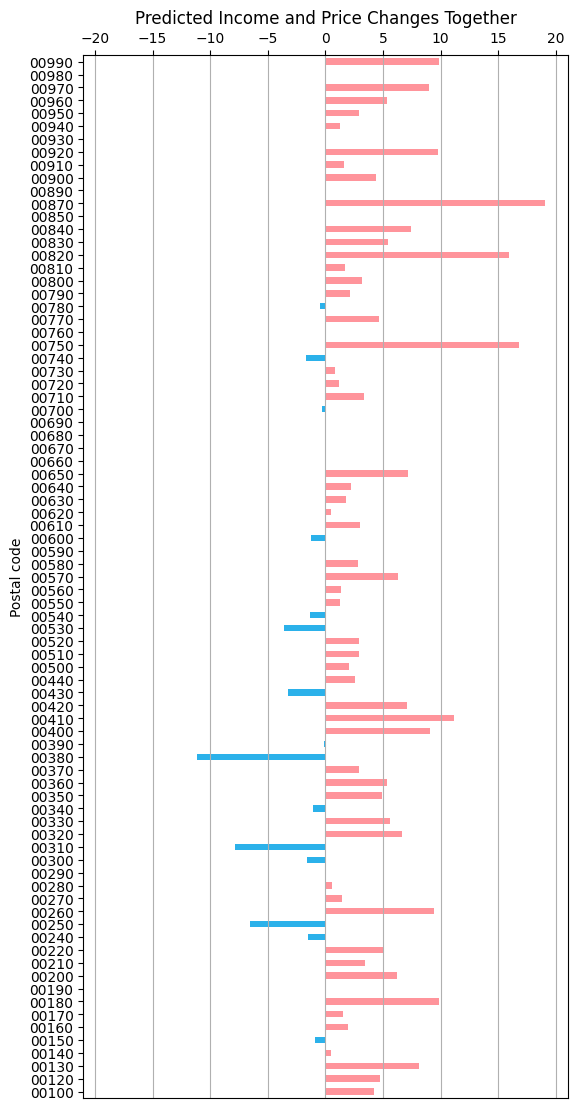

In [11]:
# Plot the percent changes.
limit = results['Percent Change'].map(lambda _: abs(_)).max()
_ = results['Percent Change'].plot(color = np.where(results['Percent Change'] < 0, '#2BB1EA', '#FF949B'),
                                   figsize = (600/96, 1300/96), kind = 'barh')
_.set_title('Predicted Income and Price Changes Together')
_.set_xlim(-limit - 2, limit + 2)
_.xaxis.grid(True)
_.xaxis.tick_top()

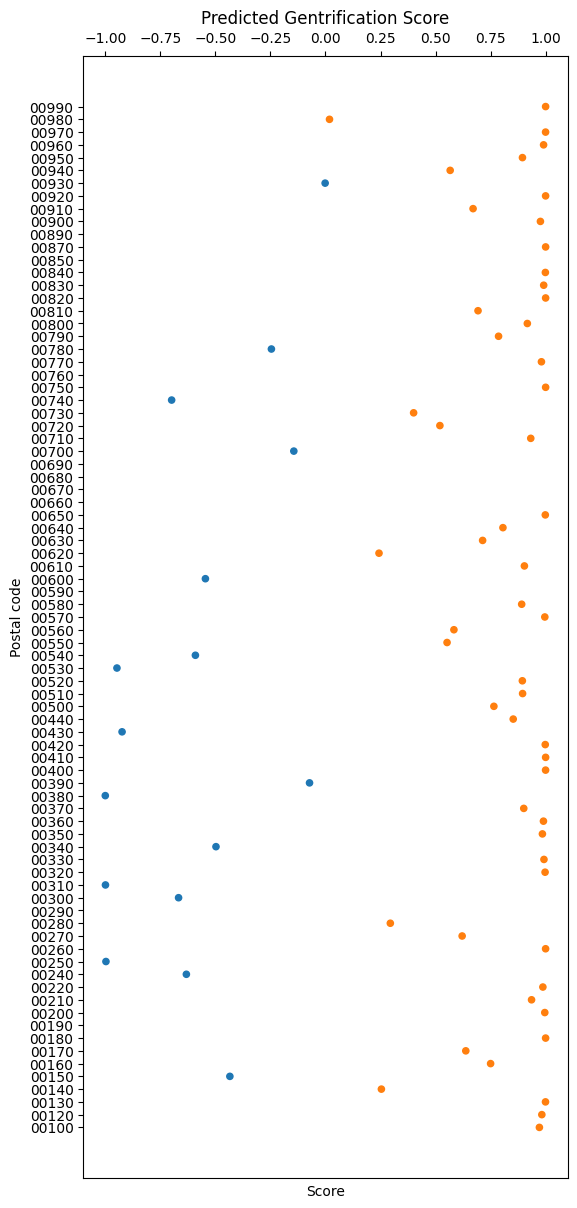

In [12]:
# Plot the "gentrification scores".
# As a side note, way too many positives: almost all areas are gentrifying according to our "analysis".
# One reason for this is that we do not take into account in any way the general increase in income
# and prices (due to, for instance, inflation, which is never 0%).
_ = results.plot.scatter(c = np.where(results['Score'] < 0, 'C0', 'C1'),
                         x = 'Score',
                         y = 'Postal code',
                         figsize = (600/96, 1400/96))
_.set_title('Predicted Gentrification Score')
_.xaxis.tick_top()

In [13]:
from os import path
from tempfile import gettempdir

json_file = path.join(gettempdir(), 'gentrification.json')
results[['Percent Change', 'Score']].to_json(json_file, indent = 2, orient = 'index')
print(f'Results written into "{json_file}".')

Results written into "/var/folders/tp/ycp57sm12qq_g7_xmm5n8s300000gn/T/gentrification.json".
